***1. Loading the Dataset  from the Google Drive Location.***

In [5]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/DLproject')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'car person.jpg'   NFL.jpg	 trained_yolo_model.h5
 coco_yolo3.h5	   __pycache__	 yolo3.py


In [ ]:
# Check Keras version (already installed)
import keras
print("Keras version:", keras.__version__)


Keras version: 3.8.0


In [2]:
# Not recommended - TF-DF 1.11.0 explicitly requires TF 2.18.0[1]
!pip install --upgrade tensorflow-decision-forests tensorflow-text tf-keras


  Using cached tensorflow_decision_forests-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.3 kB)
  Using cached tf_keras-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
Using cached tensorflow_decision_forests-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.1 MB)
Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (644.9 MB)
Using cached tf_keras-2.19.0-py3-none-any.whl (1.7 MB)
Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninst

In [1]:
!pip install --user virtualenv
!virtualenv tf18_env && source tf18_env/bin/activate
!pip install tensorflow==2.18.0 tensorflow-decision-forests


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 38.3 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
/bin/bash: line 1: virtualenv: command not found
INFO: pip is looking at multiple versions of tensorflow-decision-forests to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB

In [3]:
!pip install opencv-python

***2. Defining a Baseline Model.***

   For this project we have used the YOLO v1 as the baseline model

*  version and compared For the sake of convenience, PyTorch's pretrained ResNet50 architecture was used as the backbone for the model instead of Darknet. However, the detection layers at the end of the model exactly follow those described in the paper. The data was augmented by randomly scaling dimensions, shifting position, and adjusting hue/saturation values by up to 20% of their original values.

* Overall, the bounding boxes look convincing, though it is  interesting to note that YOLOv1 has trouble detecting tightly grouped objects as well as small, distant ones. Additionally, the fully vectorized SumSquaredLoss function achieves roughly a 4x speedup in training time compared to using a for-loop to determine bounding box responsibility.

In [19]:
import tensorflow as tf
from tensorflow import keras  # Or import keras if you used the keras version
# ... (rest of your code)

from keras.models import load_model

try:
    model = load_model('coco_yolo3.h5')
    print("✅ Model loaded successfully!")
    model.summary()
except Exception as e:
    print(f"❌ Error loading model: {e}")
    model = None


✅ Model loaded successfully!


Model: "model_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_3             │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_0 (Conv2D)     │ (None, None,      │        864 │ input_3[0][0]     │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bnorm_0             │ (None, None,      │        128 │ conv_0[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_0 (LeakyReLU) │ (None, None,      │          0 │ bnorm_0[0][0]     │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_10   │ (None, None,      │          0 │ leaky_0[0][0]     │
│ (ZeroPadding2D)     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, None,      │     18,432 │ zero_padding2d_1… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bnorm_1             │ (None, None,      │        256 │ conv_1[0][0]      │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_1 (LeakyReLU) │ (None, None,      │          0 │ bnorm_1[0][0]     │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, None,      │      2,048 │ leaky_1[0][0]     │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bnorm_2             │ (None, None,      │        128 │ conv_2[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_2 (LeakyReLU) │ (None, None,      │          0 │ bnorm_2[0][0]     │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, None,      │     18,432 │ leaky_2[0][0]     │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bnorm_3             │ (None, None,      │        256 │ conv_3[0][0]      │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_3 (LeakyReLU) │ (None, None,      │          0 │ bnorm_3[0][0]     │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_46 (Add)        │ (None, None,      │          0 │ leaky_1[0][0],    │
│                     │ None, 64)         │            │ leaky_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_11   │ (None, None,      │          0 │ add_46[0][0]      │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_5 (Conv2D)     │ (None, None,      │     73,728 │ zero_padding2d_1

 Total params: 62,001,757 (236.52 MB)

 Trainable params: 61,949,149 (236.32 MB)

 Non-trainable params: 52,608 (205.50 KB)

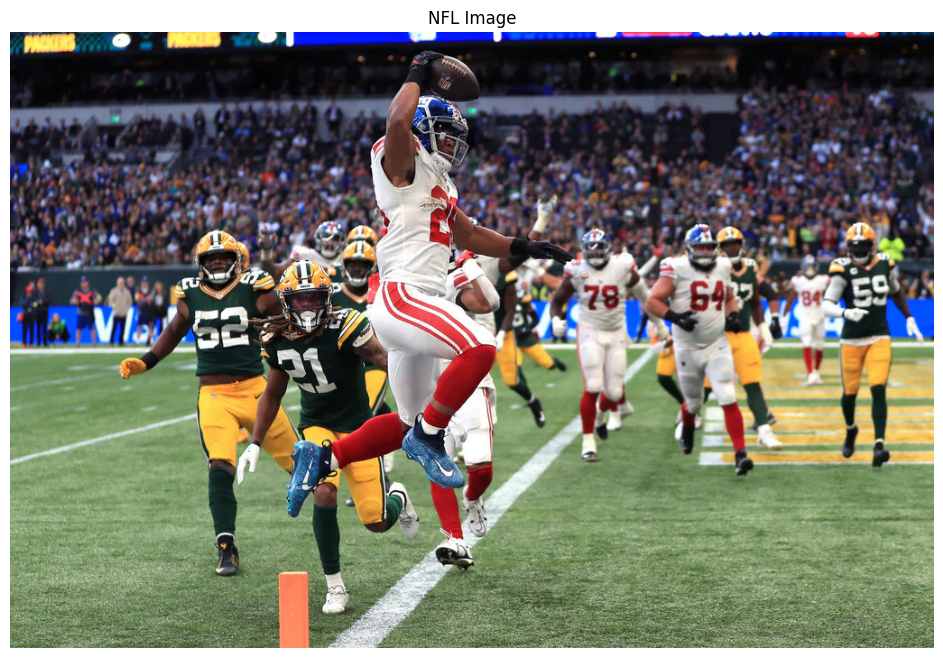

In [7]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("NFL.jpg")
if image is None:
    raise ValueError("❌ Image could not be loaded. Check filename or format.")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.title("NFL Image")
plt.axis("off")
plt.show()


In [8]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

# Resize to YOLO input shape (416x416 is most common for YOLOv3)
x = load_img('NFL.jpg', target_size=(416, 416))
x = img_to_array(x) / 255.0
x = np.expand_dims(x, axis=0)

# Run prediction
y = model.predict(x)
print("✅ Prediction done")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
✅ Prediction done


In [10]:
from yolo3 import *
net_h, net_w = 416, 416
obj_thresh = 0.5
nms_thresh = 0.45

anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]


In [11]:
import keras.layers

# Patch for compatibility with old YOLOv3 code
add = keras.layers.Add()
concatenate = keras.layers.Concatenate()



In [12]:
from yolo3 import *


In [13]:
image_path = "NFL.jpg"
image = cv2.imread(image_path)
image_h, image_w, _ = image.shape

input_image = preprocess_input(image.copy(), net_h, net_w)
yolos = model.predict(input_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


person: 79.41283%
person: 99.375465%
person: 63.56518%
person: 92.48308%
person: 99.5433%
person: 99.90666%
person: 99.246475%
person: 99.71257%
person: 94.88426%
person: 93.91558%
person: 93.92695%
person: 96.4901%
person: 59.267937%
person: 54.478752%


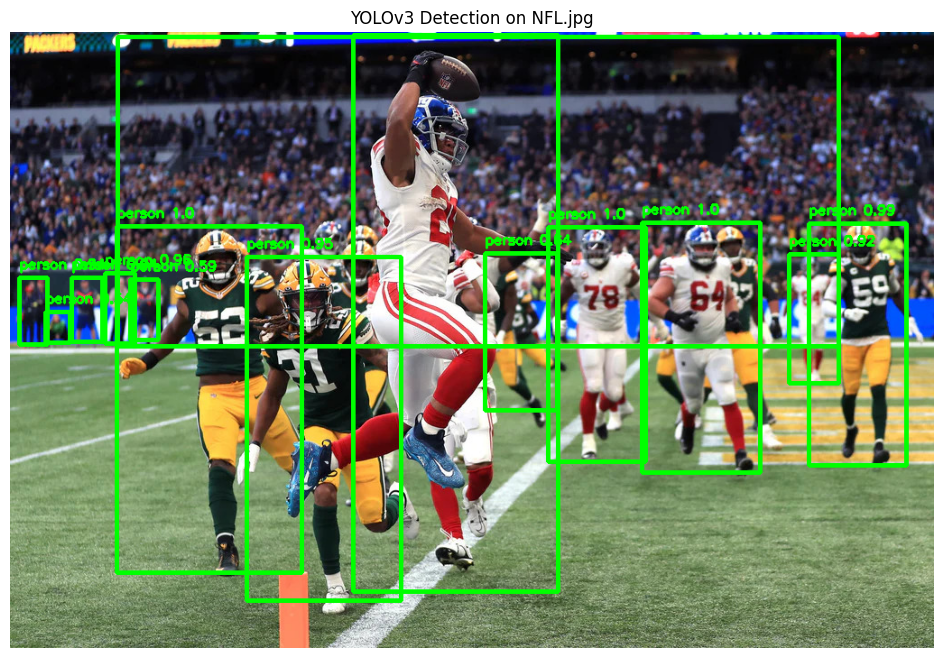

In [14]:
boxes = []
for i in range(len(yolos)):
    boxes += decode_netout(yolos[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)

correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)
do_nms(boxes, nms_thresh)

# Draw boxes
output_image = draw_boxes(image.copy(), boxes, labels, obj_thresh)

# Show the result
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("YOLOv3 Detection on NFL.jpg")
plt.show()


In [15]:
labels

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

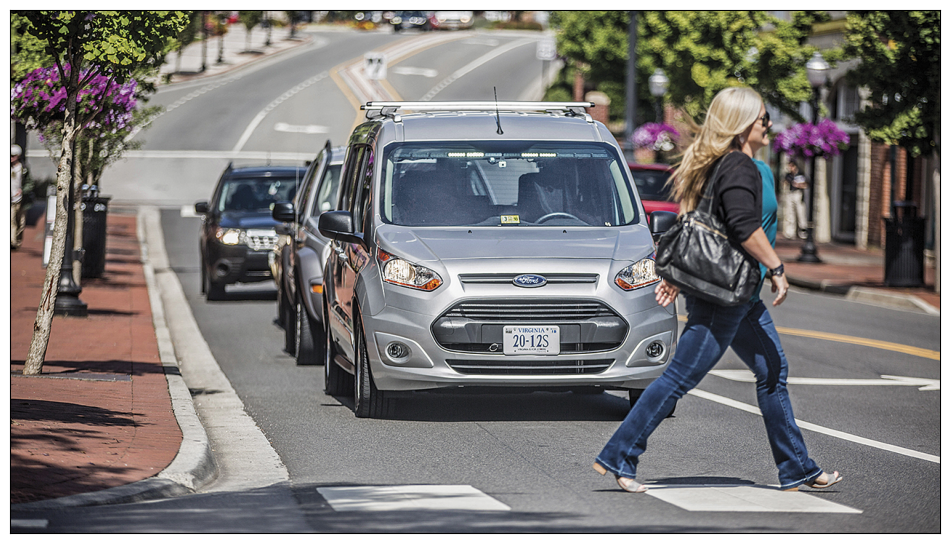

In [16]:
image = plt.imread('car person.jpg')
width, height = image.shape[1], image.shape[0]
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

In [17]:
x = load_img('car person.jpg', target_size=(416, 416))
x = img_to_array(x) / 255
x = np.expand_dims(x, axis=0)
y = model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
car: 96.51604%
person: 99.95523%
car: 98.32514%
handbag: 88.46385%
car: 88.89172%
car: 84.24521%
person: 65.44292%


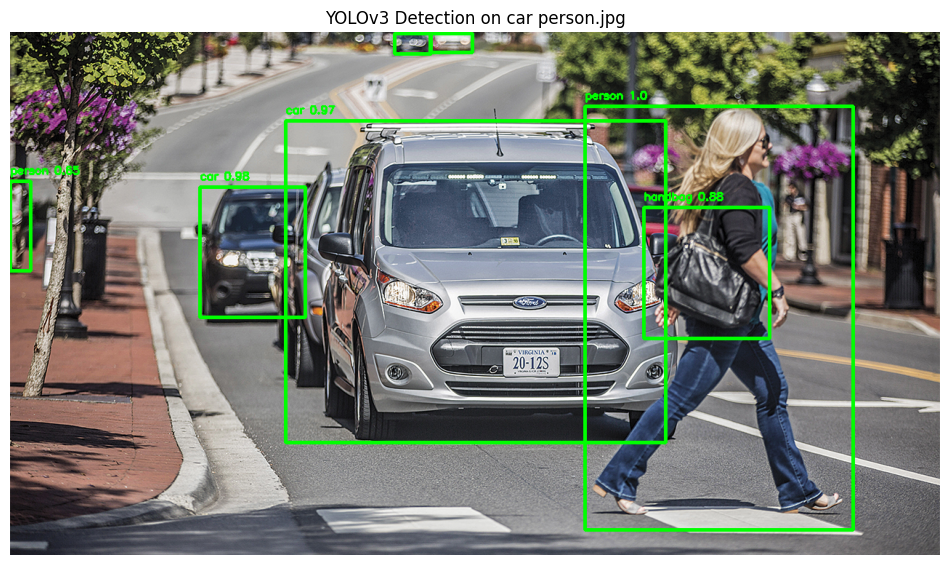

In [18]:
from yolo3 import *

image_path = "car person.jpg"
image = cv2.imread(image_path)

if image is None:
    raise ValueError(f"❌ Could not load image: {image_path}")

image_h, image_w, _ = image.shape

input_image = preprocess_input(image.copy(), net_h, net_w)
yolos = model.predict(input_image)

boxes = []
for i in range(len(yolos)):
    boxes += decode_netout(yolos[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)

correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)
do_nms(boxes, nms_thresh)

output_image = draw_boxes(image.copy(), boxes, labels, obj_thresh)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"YOLOv3 Detection on {image_path}")
plt.show()

